In [1]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
from math import log
import random
from itertools import combinations
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, mannwhitneyu, f_oneway
from nltk.metrics.agreement import AnnotationTask

# Setup
%matplotlib inline
sns.set_style('white')
sns.set_context('paper', font_scale=1)
sns.set_style('ticks', {'xtick.color': '0','ytick.color': '0'})
cmap = sns.cubehelix_palette(start=0, rot=0, dark=.1, light=.9, hue=0,as_cmap=True)
cmap_color = sns.cubehelix_palette(start=2.7, rot=0, dark=0.25, light=.9, as_cmap=True)
palette = sns.cubehelix_palette(start=0, rot=0, dark=.1, light=.9, hue=0)

# Globals
ATTRIBUTES = ['Relevance','Rhetorical Quality','Logical Quality','Dialectical Quality']

## Data Import

In [2]:
df_arguments = pd.read_csv("./Data/arguments.csv")
df_annotators = pd.read_csv("./Data/annotators.csv")
df_topics = pd.read_csv("./Data/topics.csv")
df_rankings = pd.read_csv("./Data/rankings.csv")

## Annotators

Distribution of age per gender:

In [3]:
male =  (
    df_annotators
    .loc[df_annotators['Gender'] == 'male',['Age']]
    .describe()
    .rename({"Age":"Male"},axis=1)
    .round(2)
)
female = (
    df_annotators
    .loc[df_annotators['Gender'] == 'female',['Age']]
    .describe()
    .rename({"Age":"Female"},axis=1)
    .round(2)
)
female.join(male)

,Female,Male
count,8.00,31.00
mean,28.00,23.97
std,15.46,7.61
min,18.00,19.00
25%,19.75,19.00
50%,20.00,20.00
75%,29.00,24.50
max,53.00,38.00


# Argument Quality

## Corpus statistics

In [4]:
print('Number of items: {}'.format(len(df_arguments)))
print('Number of arguments: {}'.format(len(df_arguments.loc[df_arguments['Is Argument?'] == True])))
print('Number of non-arguments: {}'.format(len(df_arguments.loc[df_arguments['Is Argument?'] == False])))
print('Number of unique arguments: {}'.format(len(df_arguments.drop_duplicates(subset=['Discussion ID','Argument ID'],keep=False))))

Number of items: 494
Number of arguments: 437
Number of non-arguments: 57
Number of unique arguments: 252


## Distribution

Count Pro/Con-Arguments:

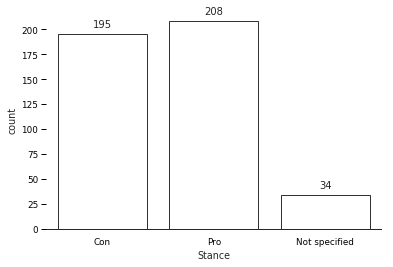

In [5]:
f = sns.countplot(df_arguments.loc[(df_arguments['Is Argument?'] == True),'Stance'], color="w",edgecolor='k')
sns.despine(left=True,bottom=False,right=True,top=True)
for p in f.patches:
        f.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', rotation=0, xytext=(0, 10), textcoords='offset points')
f.tick_params(bottom=False)
f.get_figure().savefig("./plots/attributes_distribution_stance.eps",format='eps',dpi=300)

Overall distribution of argument quality scores:

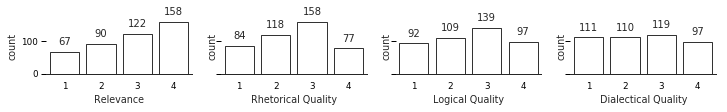

In [6]:
f, axes = plt.subplots(1, 4, figsize=(12, 1), sharey=True)
sns.despine(left=True,bottom=True,right=True,top=True)

for i,quality in enumerate(ATTRIBUTES):
    sns.countplot(df_arguments.loc[(df_arguments['Is Argument?'] == True),quality], color="w",edgecolor='k', ax=axes[i]).tick_params(bottom=False)
    for p in axes[i].patches:
        axes[i].annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', rotation=0, xytext=(0, 10), textcoords='offset points')
sns.despine(bottom=False,left=True)
f.savefig("./plots/attributes_distribution_full.eps",format='eps',dpi=300)

## Correlation

Considering all Arguments:

In [7]:
df_arguments.loc[(df_arguments['Is Argument?']==True),ATTRIBUTES].corr(method='pearson').round(2)

,Relevance,Rhetorical Quality,Logical Quality,Dialectical Quality
Relevance,1.00,0.38,0.48,0.70
Rhetorical Quality,0.38,1.00,0.65,0.60
Logical Quality,0.48,0.65,1.00,0.69
Dialectical Quality,0.70,0.60,0.69,1.00


In [8]:
df_arguments.loc[(df_arguments['Is Argument?']==True),ATTRIBUTES].corr(method='spearman').round(2)

,Relevance,Rhetorical Quality,Logical Quality,Dialectical Quality
Relevance,1.00,0.40,0.48,0.71
Rhetorical Quality,0.40,1.00,0.65,0.59
Logical Quality,0.48,0.65,1.00,0.69
Dialectical Quality,0.71,0.59,0.69,1.00


Per stance:

In [9]:
df_corr_full = (
    df_arguments
    .loc[(df_arguments['Is Argument?']==True)&(df_arguments['Stance']!='Not specified'),['Stance',*ATTRIBUTES]]
    .groupby('Stance')
    .corr(method='pearson')
    .round(2)
    .transpose()
)
df_corr_full.columns = df_corr_full.columns.swaplevel(0, 1)
df_corr_full.sortlevel(0, axis=1, inplace=True)
df_corr_full

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  # Remove the CWD from sys.path while we load stuff.


Dialectical Quality       Logical Quality       Relevance  \
Stance                              Con   Pro             Con   Pro       Con   
Dialectical Quality                1.00  1.00            0.68  0.70      0.73   
Logical Quality                    0.68  0.70            1.00  1.00      0.47   
Relevance                          0.73  0.68            0.47  0.48      1.00   
Rhetorical Quality                 0.56  0.62            0.64  0.66      0.34   

                          Rhetorical Quality        
Stance                Pro                Con   Pro  
Dialectical Quality  0.68               0.56  0.62  
Logical Quality      0.48               0.64  0.66  
Relevance            1.00               0.34  0.42  
Rhetorical Quality   0.42               1.00  1.00

## Agreement

In [10]:
from math import pow
def distance(label1, label2):
    return pow((sum(range(label1,label2+1)) - (label1+label2)/2),2)

for dimension in ATTRIBUTES[1:]:
    df_multiples = (  
        df_arguments
        .loc[(df_arguments.duplicated(subset=['Argument ID','Discussion ID'],keep=False))&(df_arguments['Is Argument?']==True),:]
                .groupby(['Discussion ID','Argument ID'])
                .count()
                .reset_index()
        .loc[
            (
                df_arguments
                .loc[(df_arguments.duplicated(subset=['Argument ID','Discussion ID'],keep=False))&(df_arguments['Is Argument?']==True),:]
                .groupby(['Discussion ID','Argument ID'])
                .count()
                .reset_index()
            )['Topic ID'] == 2
            ,['Discussion ID','Argument ID']
        ]
        .merge(df_arguments,how='left',on=['Discussion ID','Argument ID'])
    ).loc[:,[dimension,'Discussion ID','Argument ID']]

    df_multiples['Annotation Set'] = df_multiples.groupby(['Discussion ID','Argument ID']).cumcount()
    df_multiples['Unique'] = df_multiples.apply(lambda x : str(x['Discussion ID'])+"-"+str(x['Argument ID']), axis=1)
    df_multiples = df_multiples.pivot(index = 'Annotation Set',values=dimension,columns='Unique')
    df_multiples.columns = range(0,len(df_multiples.columns))
    df_multiples = df_multiples.reset_index(drop=True)

    annotation_triples = []
    for annotator,annotation_set in enumerate(df_multiples.itertuples(index=False)):
        for i, annotation in enumerate(annotation_set):
            annotation_triples.append((annotator,i,annotation))

    t = AnnotationTask(annotation_triples, distance=distance)
    print(dimension,round(t.alpha(),2))

Rhetorical Quality 0.27
Logical Quality 0.26
Dialectical Quality 0.32


## Bias

Mean argument scores by anntator stance cross-tabulation. No significant effect of annotator stance towards the topic.

In [11]:
df_bias = pd.DataFrame(index=pd.MultiIndex(levels=[['I agree', 'I disagree', 'Neutral'], ['Mean', 'p-value']],
           labels=[[0, 1, 2, 0, 1, 2], [0, 0, 0, 1, 1, 1]],
           names=['Annotator Stance', 'Value']),columns=ATTRIBUTES)

sample = (
    df_topics[df_topics['Biased']==True]
    .merge(df_arguments[(df_arguments['Stance']!='Not specified')&(df_arguments['Is Argument?']==True)], how='left',on='Topic ID')
    .loc[:,['Annotator Stance','Stance',*ATTRIBUTES]]
)

for ann_stance in ['I agree', 'I disagree','Neutral']:
    for dimension in ATTRIBUTES:
        s1 = sample.loc[(sample['Annotator Stance']==ann_stance)&(sample['Stance']=='Pro'),dimension]
        s2 = sample.loc[(sample['Annotator Stance']==ann_stance)&(sample['Stance']=='Con'),dimension]
        p = mannwhitneyu(s1,s2)[1]
        df_bias.loc[(ann_stance,'Mean'),dimension] = (s1.median().round(2),s2.median().round(2))
        df_bias.loc[(ann_stance,'p-value'),dimension] = round(p,4)

df_bias = df_bias.rename({'I agree':'Pro','I disagree':'Con'})
df_bias

,,Relevance,Rhetorical Quality,Logical Quality,Dialectical Quality
Annotator Stance,Value,,,,
Pro,Mean,"(3.0, 2.0)","(3.0, 2.5)","(3.0, 2.0)","(2.0, 2.0)"
Con,Mean,"(3.0, 3.0)","(3.0, 3.0)","(3.0, 3.0)","(3.0, 3.0)"
Neutral,Mean,"(3.0, 3.0)","(3.0, 3.0)","(2.0, 2.0)","(2.0, 2.0)"
Pro,p-value,0.1112,0.1575,0.088,0.0888
Con,p-value,0.4766,0.0908,0.1774,0.4054
Neutral,p-value,0.3349,0.0951,0.2612,0.2815


In [12]:
(
    df_topics[(df_topics['Biased']==True) & df_topics.index.isin([0,2,5,7,13,15,16,17])]
    .merge(df_arguments[(df_arguments['Stance']!='Not specified')&(df_arguments['Is Argument?']==True)], how='left',on='Topic ID')
    .loc[:,['Annotator Stance','Stance',*ATTRIBUTES]]
    .groupby(['Annotator Stance','Stance'],axis=0)
    .count()
    .round(2)
    .unstack('Stance')
)

Relevance     Rhetorical Quality     Logical Quality      \
Stance                 Con Pro                Con Pro             Con Pro   
Annotator Stance                                                            
I agree                 11  11                 11  11              11  11   
I disagree              24  27                 24  27              24  27   
Neutral                  3   2                  3   2               3   2   

                 Dialectical Quality      
Stance                           Con Pro  
Annotator Stance                          
I agree                           11  11  
I disagree                        24  27  
Neutral                            3   2

## Ranking

In [13]:
def ndcg(ideal_ranking, real_ranking, k):
    """
    :param ideal_ranking: list of ideal ranking entry tuples in the form of (rank,value)
    :param real_ranking: list of real ranking entry tuples in the form of (rank,value)
    :param k: first k entries of the ranking are used to calculate the dcg score
    :param normalize_fnc: function used to normalize passed values
    :return: normalized discounted cumluative gain at k for passed ideal and real ranking
    """
    dcg = lambda ranking,k : sum([(2**value - 1) / log(1 + rank, 2) for rank, value in ranking[0:k]])
    return dcg(real_ranking,k) / dcg(ideal_ranking,k)

#### Mean NDCG Scores Overall

In [14]:
dfs_ndcg = []

for engine in df_rankings['Engine'].unique(): # Per engine
    for dimension in ATTRIBUTES: # Per quality dimensions
        for topic in df_topics['Topic ID'].unique(): # Per topic
            real_ranking = (
                df_rankings
                .loc[(df_rankings['Engine'] == engine) & (df_rankings['Topic ID'] == topic),:] # Consider only rankings for current engine & topic
                .sort_values('Rank',axis=0,ascending=True) # Sort Ranking from low to high
                .merge(df_arguments,how='left',on=['Discussion ID','Argument ID','Topic ID']) # Add argument qualities for every argument in the ranking
            )
            ideal_ranking = (
                df_arguments
                .loc[df_arguments['Topic ID'] == topic,:]
                .sort_values(dimension, axis=0, ascending=False)  # Sort from high to low for current dimension
            )
            score = ndcg([t for t in enumerate(list(ideal_ranking[dimension]),start=1)],[t for t in enumerate(list(real_ranking[dimension]),start=1)],5)
            dfs_ndcg.append({"Engine":engine,"Dimension":dimension,"NDCG-Score":score,"Topic":topic})

df_ndcg = pd.DataFrame(dfs_ndcg)

In [15]:
(
    df_ndcg
    .drop("Topic",axis=1)
    .groupby(["Engine","Dimension"], axis=0)
    .mean()
    .round(2)
    .unstack('Dimension')
)

NDCG-Score                                             
Dimension   Dialectical Quality Logical Quality Relevance Rhetorical Quality
Engine                                                                      
BM25F                      0.42            0.42      0.46               0.45
DPH                        0.65            0.64      0.66               0.67
DirichletLM                0.65            0.69      0.64               0.70
TF_IDF                     0.47            0.49      0.56               0.46

#### Bootstrapping for confidence intervals

In [16]:
n = 10000
a = 0.05

df_confidence = []
for engine in df_ndcg['Engine'].unique():
    for dimension in ATTRIBUTES:
        samples = sorted([
                (
                    df_ndcg
                    .loc[(df_ndcg['Engine'] == engine) & (df_ndcg['Dimension'] == dimension),'NDCG-Score']
                    .sample(replace=True,frac=1)
                    .mean()
                ) 
                for i in range(n)
        ])
        lower = samples[int(len(samples)*a)]
        upper = samples[int(len(samples)*(1-a))]
        df_confidence.append({"Engine":engine,"Dimension":dimension,"Lower Bound":lower,"Upper Bound":upper})

df_confidence = pd.DataFrame(df_confidence)
df_confidence = df_confidence.pivot(index='Engine',columns='Dimension',values=['Upper Bound','Lower Bound'])
df_confidence.columns = df_confidence.columns.swaplevel(0,1)
df_confidence.sort_index(level=0, axis=1, inplace=True)
df_confidence.reindex(["DirichletLM", "DPH", "TF_IDF","BM25F"]).round(2)

Dimension   Dialectical Quality             Logical Quality              \
                    Lower Bound Upper Bound     Lower Bound Upper Bound   
Engine                                                                    
DirichletLM            0.596807    0.700837        0.645474    0.736482   
DPH                    0.589655    0.699749        0.582455    0.694702   
TF_IDF                 0.405697    0.537628        0.426577    0.550085   
BM25F                  0.372471    0.475565        0.370027    0.469160   

Dimension     Relevance             Rhetorical Quality              
            Lower Bound Upper Bound        Lower Bound Upper Bound  
Engine                                                              
DirichletLM    0.595977    0.689497           0.651815    0.738056  
DPH            0.614692    0.712424           0.614202    0.723802  
TF_IDF         0.490467    0.617900           0.390730    0.535363  
BM25F          0.407315    0.508053           0.395687    0.495403

#### ANOVA Significance Testing

In [17]:
df_significance = pd.DataFrame(index=pd.MultiIndex.from_product([ATTRIBUTES,df_ndcg['Engine'].unique()], names=['Dimension', 'Engine']),columns=df_ndcg['Engine'].unique())
for engine1,engine2 in combinations(df_ndcg['Engine'].unique(),2):
    for dimension in ATTRIBUTES:
        t1 = (
            df_ndcg
            .loc[(df_ndcg['Engine'] == engine1) & (df_ndcg['Dimension'] == dimension),'NDCG-Score']
        )
        t2 = (
            df_ndcg
            .loc[(df_ndcg['Engine'] == engine2) & (df_ndcg['Dimension'] == dimension),'NDCG-Score']
        )
        stat, p = f_oneway(t1,t2)
        df_significance.loc[(dimension,engine1),engine2] = p.round(4)
df_significance.dropna(how='all').fillna('').transpose()

Dimension   Relevance                     Rhetorical Quality          \
Engine          BM25F     DPH DirichletLM              BM25F     DPH   
BM25F                                                                  
DPH                 0                                      0           
DirichletLM         0  0.6225                              0  0.5777   
TF_IDF         0.0562  0.0313      0.0724             0.7425  0.0004   

Dimension               Logical Quality                      \
Engine      DirichletLM           BM25F     DPH DirichletLM   
BM25F                                                         
DPH                                   0                       
DirichletLM                           0  0.2472               
TF_IDF                0           0.164  0.0047      0.0001   

Dimension   Dialectical Quality                      
Engine                    BM25F     DPH DirichletLM  
BM25F                                                
DPH                           0                      
DirichletLM                   0  0.9488              
TF_IDF                   0.3446  0.0015       0.001

#### NDCG Variance

In [18]:
(
    df_ndcg
    .drop("Topic",axis=1)
    .groupby(["Engine","Dimension"], axis=0)
    .var()
    .round(4)
    .unstack('Dimension')
)

NDCG-Score                                             
Dimension   Dialectical Quality Logical Quality Relevance Rhetorical Quality
Engine                                                                      
BM25F                    0.0406          0.0377    0.0399             0.0371
DPH                      0.0452          0.0475    0.0374             0.0449
DirichletLM              0.0407          0.0317    0.0326             0.0279
TF_IDF                   0.0654          0.0596    0.0612             0.0791